In [1]:
!which python

/Users/ahmadabdullahtariq/Documents/Projects/Thesis/.venv/bin/python


# Single Hotel Experiments
- for pipelines https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

## Helping functions
- Plot

In [2]:
def plot_booking_curve(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['SnapshotDate'], y=df['Rooms'],mode='lines',name='Max Capacity'))
    fig.add_trace(go.Scatter(x=df['SnapshotDate'], y=df['Definitive'],mode='lines+markers',name='ROH'))
    fig.show()

def plot_price_line(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['SnapshotDate'], y=df['LAR'],mode='lines',name='Price'))
    fig.show()    

def plot_definative(df):
    fig = go.Figure(data=go.Heatmap(x=df['TargetDate'], y=df['SnapshotDate'], z=df['Definitive'], colorscale='Viridis'))
    fig.update_layout(
                    title='Definative Values of Hotel',
                    xaxis=dict(
                        #     rangeselector=dict(
                        #         buttons=list([
                        #                 dict(count=1,label="1m",step="month",stepmode="backward"),
                        #                 dict(count=6,label="6m",step="month",stepmode="backward"),
                        #                 dict(count=1,label="YTD",step="year",stepmode="todate"),
                        #                 dict(count=1,label="1y",step="year",stepmode="backward"),
                        #                 dict(step="all")])
                        #     ),

                            rangeslider=dict(visible=True),
                            type="date", 
                            title_text = "Target date"
                    ), 
                    yaxis = dict(title_text = 'Lead Time (days)',autorange="reversed")
     )
    return fig    

def plot_price(df):
    fig = go.Figure(data=go.Heatmap(x=df['TargetDate'], y=df['SnapshotDate'], z=df['LAR'], colorscale='Viridis'))
    fig.update_layout(
                    title='Price Values of Hotel',
                    xaxis=dict(
                        #     rangeselector=dict(
                        #         buttons=list([
                        #                 dict(count=1,label="1m",step="month",stepmode="backward"),
                        #                 dict(count=6,label="6m",step="month",stepmode="backward"),
                        #                 dict(count=1,label="YTD",step="year",stepmode="todate"),
                        #                 dict(count=1,label="1y",step="year",stepmode="backward"),
                        #                 dict(step="all")])
                        #     ),

                            rangeslider=dict(visible=True),
                            type="date", 
                            title_text = "Target date"
                    ), 
                    yaxis = dict(title_text = 'Lead Time (days)',autorange="reversed")
     )
    return fig    

## Data Preperation
- Retriving Occupancy and price data for 60 berlin hotel 
- Select and filter one hotel with consistant data
-  Drop columns that don't add value, and duplicate entries

In [7]:
# retriving data from files
df_occ = pd.read_pickle('../dataset/preprocessed/occupancy.pkl')
df_pri = pd.read_pickle('../dataset/preprocessed/price.pkl')

# clean_hotels = [1041, 269, 4290, 48, 317, 151, 322, 1968, 1100, 284, 86, 199, 80, 577, 148, 1479] 

# filter data for hotel 284
df_occ = df_occ[df_occ.HotelId==1041]
df_pri = df_pri[df_pri.HotelId==1041]

# dropping columns that we are not going to use
df_occ = df_occ.drop(columns=['LeadTime', 'HotelId'])
df_pri = df_pri.drop(columns=['LeadTime', 'HotelId'])

# drop duplicates 
df_occ = df_occ.drop_duplicates(subset=['TargetDate', 'SnapshotDate'], keep='last')
df_pri = df_pri.drop_duplicates(subset=['TargetDate', 'SnapshotDate'], keep='last')

- Definitive and Rooms have NaN so we can't convert them astype int. 
- Work around this is to convert it into float, this would make it easier to fill in next steps

In [8]:
df_occ['Definitive'] = df_occ['Definitive'].astype('float')
df_occ['Rooms']      = df_occ['Rooms'].astype('float')

# confirm dtypes of colums
print("Length of Occupancy : ",len(df_occ))
print(df_occ.dtypes)
print("\nLength of Price : ",len(df_pri))
print(df_pri.dtypes)

Length of Occupancy :  73161
TargetDate      datetime64[ns]
Definitive             float64
Rooms                  float64
SnapshotDate    datetime64[ns]
dtype: object

Length of Price :  71325
TargetDate      datetime64[ns]
LAR                    float64
SnapshotDate    datetime64[ns]
dtype: object


In [9]:
print('Occupancy DataFrame')
print(df_occ.head())
print('\nPrice DataFrame')
print(df_pri.head())

Occupancy DataFrame
        TargetDate  Definitive  Rooms SnapshotDate
2420500 2018-01-01       191.0  848.0   2017-10-04
2420499 2018-01-01       191.0  848.0   2017-10-06
2420498 2018-01-01       191.0  848.0   2017-10-09
2420497 2018-01-01       203.0  848.0   2017-10-11
2420496 2018-01-01       203.0  820.0   2017-10-13

Price DataFrame
       TargetDate   LAR SnapshotDate
519796 2018-01-01   NaN   2017-12-18
521244 2018-01-11  48.5   2018-01-11
521387 2018-01-12  59.0   2018-01-11
521529 2018-01-13  59.0   2018-01-11
521682 2018-01-14  48.5   2018-01-11


- We can see that length of both dataframe is different
- So we are going to use outter joing to include all possible dates and their development

In [10]:
df = pd.merge(df_occ, df_pri, left_on=['TargetDate','SnapshotDate'], right_on=['TargetDate','SnapshotDate'], how='outer')

Some preprocessing steps
- Sort according to TargetDate and Snapshot dataset
- Drop duplicate entries 
- Reset index

In [11]:
df = df.sort_values(by=['TargetDate','SnapshotDate'])
df = df.drop_duplicates(subset=['TargetDate', 'SnapshotDate'], keep='last')
df = df.reset_index(drop=True)

## Visualize Data

In [12]:
dx = df[df['TargetDate']=='2018-03-01']

In [1]:
# plot_booking_curve(dx)
# plot_price_line(dx)

## Imputation
- We can see from Plots above we have a lot of missing values 
- We are going to apply forward and then backword fill

In [14]:
# df.to_pickle('../dataset/preprocessed/284_raw.pkl') 

In [15]:
# df = pd.read_pickle('../dataset/preprocessed/284_raw.pkl')

In [16]:
print(df.dtypes,'\n')
print(df.isna().sum(),'\n')
df.describe()

TargetDate      datetime64[ns]
Definitive             float64
Rooms                  float64
SnapshotDate    datetime64[ns]
LAR                    float64
dtype: object 

TargetDate          0
Definitive      12597
Rooms           12597
SnapshotDate        0
LAR             27770
dtype: int64 



Definitive         Rooms           LAR
count  73161.000000  73161.000000  57988.000000
mean     431.133555    820.006889     80.952586
std      180.987263      0.439141     34.992102
min        1.000000    820.000000     36.000000
25%      320.000000    820.000000     57.600000
50%      450.000000    820.000000     75.600000
75%      573.000000    820.000000     93.600000
max      791.000000    848.000000    816.000000

- There are alot of missing entries in Definitive, Rooms and LAR
- We are going to impute it

Visualizing Data without imputation
- Each column in the Plot represent 90 days development of a target date

In [2]:
# plot_definative(df).show()
# plot_price(df).show()

- Forward and Backword fill within each target date.

In [18]:
targetdates = df['TargetDate'].unique()
# Bad solution
for targetdate in targetdates:
    df[df['TargetDate']==targetdate] = df[df['TargetDate']==targetdate].ffill().bfill()
    df[df['TargetDate']==targetdate] = df[df['TargetDate']==targetdate].ffill().bfill()
    df[df['TargetDate']==targetdate] = df[df['TargetDate']==targetdate].ffill().bfill()

In [3]:
# plot_definative(df).show()
# plot_price(df).show()

In [60]:
df.isna().sum()

TargetDate         0
Definitive         0
Rooms              0
SnapshotDate       0
LAR             1001
dtype: int64

- There are still some missing values we can are dropping them

In [20]:
df = df[~df['LAR'].isna()]

In [21]:
# replace zero entries of rooms with forwardfill
df['Rooms'] = df['Rooms'].replace(to_replace=0, method='ffill')
# normalize overbooking
df.loc[(df['Definitive']>df['Rooms']),'Definitive'] = df[df['Definitive']>df['Rooms']]['Rooms']

In [22]:
dx = df[df['TargetDate']=='2018-01-01']

In [4]:
# plot_booking_curve(dx)
# plot_price_line(dx)

In [24]:
# consider data for 2018 and 2019
df = df[df['TargetDate']<='2019-12-31']
# creating new columns
df['SnapshotDate'] = (df['TargetDate']-df['SnapshotDate']).dt.days
df['DOW'] = df.TargetDate.dt.dayofweek
# df = df.drop(columns=['SnapshotDate'])
# just rearrange columns 
df = df.rename(columns={'TargetDate': 'DOA','SnapshotDate':'LeadTime','DOW':'DOW','LAR':'Price','Rooms':'TotalCapacity','Definitive':'Reservations'}) 
df = df[['DOA','LeadTime','DOW','Price','TotalCapacity','ROH']]

In [26]:
# df.to_pickle('../dataset/preprocessed/284_imputed.pkl')
df.to_pickle('../dataset/preprocessed/1041_imputed.pkl')

# Data Analysis

In [27]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

In [28]:
df = pd.read_pickle('../dataset/preprocessed/1041_imputed.pkl')

print(df.isna().sum())
print(df.dtypes)

DOA              0
LeadTime         0
DOW              0
Price            0
TotalCapacity    0
Reservations     0
dtype: int64
DOA              datetime64[ns]
LeadTime                  int64
DOW                       int64
Price                   float64
TotalCapacity           float64
Reservations            float64
dtype: object


In [5]:
# dx = df[df['DOA']=='2019-06-15']

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=dx['Reservations'], y=dx['Price'],mode='lines+markers',name='Demand'))
# fig.show()   

In [30]:
df.head()

DOA  LeadTime  DOW  Price  TotalCapacity  Reservations
590 2018-01-11        87    3   48.5          820.0         114.0
591 2018-01-11        86    3   48.5          820.0         118.0
592 2018-01-11        79    3   48.5          820.0         114.0
593 2018-01-11        78    3   48.5          820.0         118.0
594 2018-01-11        77    3   48.5          820.0         118.0

In [31]:
df.describe(include='all')

DOA      LeadTime           DOW         Price  \
count                 62120  62120.000000  62120.000000  62120.000000   
unique                  719           NaN           NaN           NaN   
top     2018-07-17 00:00:00           NaN           NaN           NaN   
freq                     90           NaN           NaN           NaN   
first   2018-01-11 00:00:00           NaN           NaN           NaN   
last    2019-12-31 00:00:00           NaN           NaN           NaN   
mean                    NaN     43.888941      2.997489     89.215293   
std                     NaN     25.935551      2.001407     44.837653   
min                     NaN      0.000000      0.000000     36.000000   
25%                     NaN     21.000000      1.000000     63.900000   
50%                     NaN     44.000000      3.000000     80.100000   
75%                     NaN     66.000000      5.000000    102.600000   
max                     NaN     89.000000      6.000000    816.000000   

        TotalCapacity  Reservations  
count         62120.0  62120.000000  
unique            NaN           NaN  
top               NaN           NaN  
freq              NaN           NaN  
first             NaN           NaN  
last              NaN           NaN  
mean            820.0    485.442450  
std               0.0    148.247386  
min             820.0      4.000000  
25%             820.0    383.000000  
50%             820.0    504.000000  
75%             820.0    601.000000  
max             820.0    791.000000

In [32]:
df = df.set_index('DOA')

In [33]:
dow = [0,1,2,3,4,5,6]
weekday_counts = df.groupby('DOW').mean()
weekday_counts = weekday_counts.loc[dow]
weekday_counts

LeadTime      Price  TotalCapacity  Reservations
DOW                                                   
0    43.901404  88.064632          820.0    506.577541
1    43.903266  97.566121          820.0    498.606105
2    43.908411  98.830815          820.0    503.108252
3    43.842206  97.646995          820.0    516.349353
4    43.852660  93.065223          820.0    462.216286
5    43.916648  95.989683          820.0    493.311265
6    43.898315  53.507831          820.0    418.166742

<AxesSubplot:xlabel='DOW'>

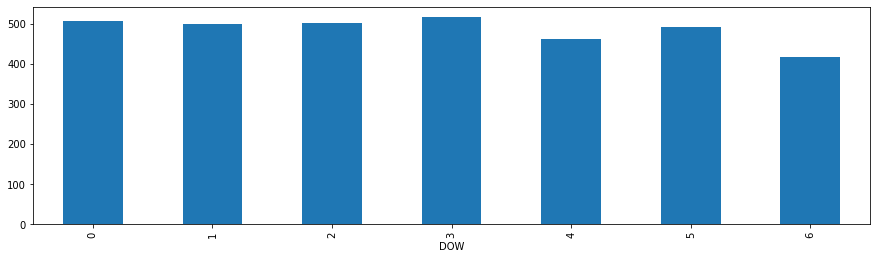

In [34]:
weekday_counts.Reservations.plot(kind='bar',figsize=(15,4))

<AxesSubplot:xlabel='DOA'>

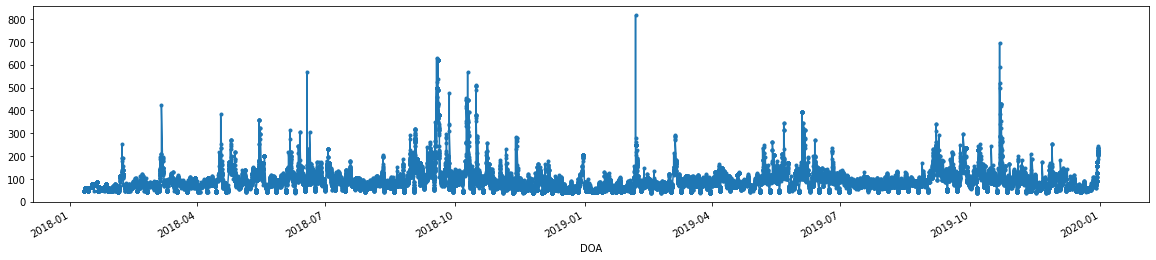

In [35]:
df.Price.plot(style='.-',figsize=(20,4))

# Change
- Definative to Leadtime (per week, days etc)

In [39]:
dz = df[df['DOA']=='2018-01-01'] 
fig = go.Figure(data=go.Scatter(
    y = dz['Price'],
    x = dz['LeadTime'],
    mode='markers',
    marker=dict(size=4, color=dz['Price'], colorscale='Viridis', showscale=True)
))
fig.update_layout(
    title="Definitive over LeadTime",
    xaxis_title="Lead Time",
    yaxis_title="Price",
    legend_title="Legend Title")
fig.show()

KeyError: 'DOA'

In [ ]:
dz = df[df['DOA']=='2019-07-15']
fig = go.Figure(data=go.Scatter(
    y = dz['Reservations'],
    x = dz['LeadTime'],
    mode='markers',
    marker=dict(size=5, color=dz['Reservations'], colorscale='Viridis', showscale=True)
))
fig.update_layout(
    title="Reservations over LeadTime",
    xaxis_title="Lead Time",
    yaxis_title="Reservations",
    legend_title="Legend Title")
fig.show()

In [ ]:
    df_0 = df[df['DOA']=='2019-02-11']
    df_1 = df[df['DOA']=='2019-02-12']
    df_2 = df[df['DOA']=='2019-02-13']
    df_3 = df[df['DOA']=='2019-02-14']
    df_4 = df[df['DOA']=='2019-02-15']
    df_5 = df[df['DOA']=='2019-02-16']
    df_6 = df[df['DOA']=='2019-02-17']
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_0['LeadTime'], y=df_0['Reservations'],mode='lines+markers',name='Mon'))
    fig.add_trace(go.Scatter(x=df_1['LeadTime'], y=df_1['Reservations'],mode='lines+markers',name='Tue'))
    fig.add_trace(go.Scatter(x=df_2['LeadTime'], y=df_2['Reservations'],mode='lines+markers',name='Wed'))
    fig.add_trace(go.Scatter(x=df_3['LeadTime'], y=df_3['Reservations'],mode='lines+markers',name='Thr'))
    fig.add_trace(go.Scatter(x=df_4['LeadTime'], y=df_4['Reservations'],mode='lines+markers',name='Fri'))
    fig.add_trace(go.Scatter(x=df_5['LeadTime'], y=df_5['Reservations'],mode='lines+markers',name='Sat'))
    fig.add_trace(go.Scatter(x=df_6['LeadTime'], y=df_6['Reservations'],mode='lines+markers',name='Sun'))

    fig.show()


In [42]:
dx = df.groupby('LeadTime')['LAR','Definitive'].describe()
count = 0
for index,row in dx.iterrows():
    print(count,'-',round(row['LAR']['mean'],1),'-',round(row['LAR']['std'],1),'-',round(row['Definitive']['mean'],1),'-',round(row['Definitive']['std'],1))
    count=count+1

KeyError: "Columns not found: 'LAR', 'Definitive'"

In [89]:
dy = df.pivot(index='TargetDate',columns='LeadTime',values='Definitive')
dy = dy.ffill(axis=1).bfill(axis=1)

In [90]:
dy[[0,7,14,21,28,35,42,49,56,63,70,77,84,89]][:30]

LeadTime       0      7      14     21     28     35     42     49    56  \
TargetDate                                                                 
2018-01-01  209.0  199.0  187.0  174.0  151.0  140.0  124.0  117.0  93.0   
2018-01-02  223.0  183.0  165.0  157.0  138.0  131.0  102.0   97.0  78.0   
2018-01-03  238.0  174.0  153.0  133.0  115.0  115.0   79.0   73.0  64.0   
2018-01-04  234.0  186.0  146.0  111.0  101.0   90.0   70.0   59.0  51.0   
2018-01-05  261.0  194.0  139.0  100.0   94.0   71.0   65.0   55.0  49.0   
2018-01-06  236.0  173.0  118.0   86.0   70.0   53.0   49.0   43.0  36.0   
2018-01-07  145.0  128.0  103.0   78.0   62.0   42.0   32.0   28.0  19.0   
2018-01-08  168.0  134.0  110.0   82.0   66.0   34.0   22.0   20.0  14.0   
2018-01-09  191.0  137.0  111.0   86.0   60.0   35.0   23.0   17.0  12.0   
2018-01-10  209.0  145.0  125.0   98.0   69.0   42.0   37.0   19.0  16.0   
2018-01-11  198.0  147.0  127.0   99.0   67.0   57.0   39.0   21.0  16.0   
2018-01-12  268.0  200.0  153.0  132.0  100.0   90.0   50.0   29.0  19.0   
2018-01-13  268.0  229.0  154.0  133.0   99.0   80.0   56.0   34.0  20.0   
2018-01-14  201.0  158.0  105.0   89.0   66.0   54.0   39.0   36.0  20.0   
2018-01-15  258.0  147.0   84.0   70.0   50.0   33.0   26.0   18.0   9.0   
2018-01-16  264.0  174.0   95.0   83.0   66.0   35.0   28.0   24.0  11.0   
2018-01-17  263.0  215.0  135.0  111.0   95.0   62.0   54.0   54.0  42.0   
2018-01-18  250.0  207.0  113.0   90.0   80.0   58.0   55.0   45.0  44.0   
2018-01-19  269.0  248.0  190.0  170.0  143.0  125.0  112.0   99.0  97.0   
2018-01-20  282.0  235.0  190.0  162.0  134.0  124.0  118.0  100.0  97.0   
2018-01-21  197.0  149.0  117.0   89.0   72.0   63.0   60.0   42.0  37.0   
2018-01-22  246.0  163.0  123.0   85.0   72.0   63.0   59.0   39.0  32.0   
2018-01-23  266.0  166.0  135.0   87.0   76.0   68.0   62.0   50.0  21.0   
2018-01-24  278.0  201.0  177.0  131.0  122.0  112.0   78.0   60.0  23.0   
2018-01-25  266.0  207.0  153.0  103.0   97.0   85.0   60.0   55.0  34.0   
2018-01-26  273.0  225.0  181.0  137.0  116.0   97.0   88.0   84.0  57.0   
2018-01-27  277.0  248.0  213.0  179.0  154.0  132.0  128.0  111.0  60.0   
2018-01-28  207.0  176.0  142.0  108.0   94.0   72.0   69.0   61.0  39.0   
2018-01-29  273.0  208.0  172.0  114.0  104.0   84.0   72.0   63.0  50.0   
2018-01-30  278.0  197.0  153.0  115.0  100.0   87.0   76.0   60.0  46.0   

LeadTime      63    70    77    84    89  
TargetDate                                
2018-01-01  85.0  72.0  69.0  63.0  58.0  
2018-01-02  72.0  60.0  54.0  51.0  48.0  
2018-01-03  54.0  46.0  42.0  39.0  36.0  
2018-01-04  48.0  39.0  35.0  33.0  32.0  
2018-01-05  41.0  36.0  31.0  27.0  26.0  
2018-01-06  32.0  27.0  22.0  19.0  19.0  
2018-01-07  18.0  17.0  13.0  10.0   9.0  
2018-01-08  14.0  13.0   9.0   7.0   5.0  
2018-01-09  12.0  12.0   8.0   6.0   5.0  
2018-01-10  13.0  14.0  10.0   8.0   8.0  
2018-01-11  16.0  15.0  12.0   6.0   6.0  
2018-01-12  15.0  13.0   8.0   4.0   4.0  
2018-01-13  15.0  12.0   7.0   6.0   3.0  
2018-01-14  10.0   7.0   3.0   3.0   3.0  
2018-01-15   3.0   3.0   2.0   1.0   1.0  
2018-01-16   6.0   6.0   5.0   5.0   3.0  
2018-01-17  10.0   7.0   6.0   6.0   4.0  
2018-01-18   7.0   6.0   5.0   5.0   4.0  
2018-01-19  85.0  79.0  75.0  75.0  69.0  
2018-01-20  89.0  78.0  77.0  75.0  69.0  
2018-01-21  28.0  20.0  20.0  18.0  12.0  
2018-01-22  23.0  16.0  15.0  12.0   6.0  
2018-01-23  12.0   6.0   5.0   3.0   3.0  
2018-01-24  14.0   8.0   7.0   4.0   4.0  
2018-01-25  25.0  17.0  16.0  14.0  13.0  
2018-01-26  44.0  27.0  26.0  25.0  25.0  
2018-01-27  50.0  36.0  29.0  28.0  27.0  
2018-01-28  30.0  18.0  17.0  16.0  16.0  
2018-01-29  47.0  12.0  11.0   9.0   9.0  
2018-01-30  47.0  13.0  12.0  11.0  11.0

In [92]:
round((dy[[0,7,14,21,28,35,42,49,56,63,70,77,84,89]][:30]/290)*100,1)

LeadTime      0     7     14    21    28    35    42    49    56    63    70  \
TargetDate                                                                     
2018-01-01  72.1  68.6  64.5  60.0  52.1  48.3  42.8  40.3  32.1  29.3  24.8   
2018-01-02  76.9  63.1  56.9  54.1  47.6  45.2  35.2  33.4  26.9  24.8  20.7   
2018-01-03  82.1  60.0  52.8  45.9  39.7  39.7  27.2  25.2  22.1  18.6  15.9   
2018-01-04  80.7  64.1  50.3  38.3  34.8  31.0  24.1  20.3  17.6  16.6  13.4   
2018-01-05  90.0  66.9  47.9  34.5  32.4  24.5  22.4  19.0  16.9  14.1  12.4   
2018-01-06  81.4  59.7  40.7  29.7  24.1  18.3  16.9  14.8  12.4  11.0   9.3   
2018-01-07  50.0  44.1  35.5  26.9  21.4  14.5  11.0   9.7   6.6   6.2   5.9   
2018-01-08  57.9  46.2  37.9  28.3  22.8  11.7   7.6   6.9   4.8   4.8   4.5   
2018-01-09  65.9  47.2  38.3  29.7  20.7  12.1   7.9   5.9   4.1   4.1   4.1   
2018-01-10  72.1  50.0  43.1  33.8  23.8  14.5  12.8   6.6   5.5   4.5   4.8   
2018-01-11  68.3  50.7  43.8  34.1  23.1  19.7  13.4   7.2   5.5   5.5   5.2   
2018-01-12  92.4  69.0  52.8  45.5  34.5  31.0  17.2  10.0   6.6   5.2   4.5   
2018-01-13  92.4  79.0  53.1  45.9  34.1  27.6  19.3  11.7   6.9   5.2   4.1   
2018-01-14  69.3  54.5  36.2  30.7  22.8  18.6  13.4  12.4   6.9   3.4   2.4   
2018-01-15  89.0  50.7  29.0  24.1  17.2  11.4   9.0   6.2   3.1   1.0   1.0   
2018-01-16  91.0  60.0  32.8  28.6  22.8  12.1   9.7   8.3   3.8   2.1   2.1   
2018-01-17  90.7  74.1  46.6  38.3  32.8  21.4  18.6  18.6  14.5   3.4   2.4   
2018-01-18  86.2  71.4  39.0  31.0  27.6  20.0  19.0  15.5  15.2   2.4   2.1   
2018-01-19  92.8  85.5  65.5  58.6  49.3  43.1  38.6  34.1  33.4  29.3  27.2   
2018-01-20  97.2  81.0  65.5  55.9  46.2  42.8  40.7  34.5  33.4  30.7  26.9   
2018-01-21  67.9  51.4  40.3  30.7  24.8  21.7  20.7  14.5  12.8   9.7   6.9   
2018-01-22  84.8  56.2  42.4  29.3  24.8  21.7  20.3  13.4  11.0   7.9   5.5   
2018-01-23  91.7  57.2  46.6  30.0  26.2  23.4  21.4  17.2   7.2   4.1   2.1   
2018-01-24  95.9  69.3  61.0  45.2  42.1  38.6  26.9  20.7   7.9   4.8   2.8   
2018-01-25  91.7  71.4  52.8  35.5  33.4  29.3  20.7  19.0  11.7   8.6   5.9   
2018-01-26  94.1  77.6  62.4  47.2  40.0  33.4  30.3  29.0  19.7  15.2   9.3   
2018-01-27  95.5  85.5  73.4  61.7  53.1  45.5  44.1  38.3  20.7  17.2  12.4   
2018-01-28  71.4  60.7  49.0  37.2  32.4  24.8  23.8  21.0  13.4  10.3   6.2   
2018-01-29  94.1  71.7  59.3  39.3  35.9  29.0  24.8  21.7  17.2  16.2   4.1   
2018-01-30  95.9  67.9  52.8  39.7  34.5  30.0  26.2  20.7  15.9  16.2   4.5   

LeadTime      77    84    89  
TargetDate                    
2018-01-01  23.8  21.7  20.0  
2018-01-02  18.6  17.6  16.6  
2018-01-03  14.5  13.4  12.4  
2018-01-04  12.1  11.4  11.0  
2018-01-05  10.7   9.3   9.0  
2018-01-06   7.6   6.6   6.6  
2018-01-07   4.5   3.4   3.1  
2018-01-08   3.1   2.4   1.7  
2018-01-09   2.8   2.1   1.7  
2018-01-10   3.4   2.8   2.8  
2018-01-11   4.1   2.1   2.1  
2018-01-12   2.8   1.4   1.4  
2018-01-13   2.4   2.1   1.0  
2018-01-14   1.0   1.0   1.0  
2018-01-15   0.7   0.3   0.3  
2018-01-16   1.7   1.7   1.0  
2018-01-17   2.1   2.1   1.4  
2018-01-18   1.7   1.7   1.4  
2018-01-19  25.9  25.9  23.8  
2018-01-20  26.6  25.9  23.8  
2018-01-21   6.9   6.2   4.1  
2018-01-22   5.2   4.1   2.1  
2018-01-23   1.7   1.0   1.0  
2018-01-24   2.4   1.4   1.4  
2018-01-25   5.5   4.8   4.5  
2018-01-26   9.0   8.6   8.6  
2018-01-27  10.0   9.7   9.3  
2018-01-28   5.9   5.5   5.5  
2018-01-29   3.8   3.1   3.1  
2018-01-30   4.1   3.8   3.8

## Descriptive Statistics 

In [11]:
df = pd.read_pickle('../dataset/preprocessed/284_imputed.pkl')
df['Occ'] = df['Reservations']/df['TotalCapacity']
df = df.drop(columns='TotalCapacity')

In [12]:
df.head()

DOA  LeadTime  DOW  Price  Reservations       Occ
0 2018-01-01        88    0  76.05          58.0  0.200000
1 2018-01-01        87    0  76.05          58.0  0.200000
2 2018-01-01        85    0  76.05          58.0  0.200000
3 2018-01-01        81    0  76.05          63.0  0.217241
4 2018-01-01        80    0  76.05          62.0  0.213793

In [13]:
df.shape

(60387, 6)

In [14]:
df.dtypes

DOA             datetime64[ns]
LeadTime                 int64
DOW                      int64
Price                  float64
Reservations           float64
Occ                    float64
dtype: object

In [15]:
df.describe(include='all')

DOA      LeadTime           DOW         Price  \
count                 60387  60387.000000  60387.000000  60387.000000   
unique                  719           NaN           NaN           NaN   
top     2019-02-04 00:00:00           NaN           NaN           NaN   
freq                     90           NaN           NaN           NaN   
first   2018-01-01 00:00:00           NaN           NaN           NaN   
last    2019-12-31 00:00:00           NaN           NaN           NaN   
mean                    NaN     43.568020      2.999851     77.716630   
std                     NaN     26.012538      2.003074     39.163356   
min                     NaN      0.000000      0.000000     30.240000   
25%                     NaN     21.000000      1.000000     53.820000   
50%                     NaN     43.000000      3.000000     67.160000   
75%                     NaN     66.000000      5.000000     91.620000   
max                     NaN     89.000000      6.000000    479.300000   

        Reservations           Occ  
count   60387.000000  60387.000000  
unique           NaN           NaN  
top              NaN           NaN  
freq             NaN           NaN  
first            NaN           NaN  
last             NaN           NaN  
mean      129.446470      0.446367  
std        71.517101      0.246611  
min         0.000000      0.000000  
25%        72.000000      0.248276  
50%       119.000000      0.410345  
75%       181.000000      0.624138  
max       290.000000      1.000000

In [19]:
df.groupby('Price').size()


Price
30.24       1
31.58     526
32.02      15
33.80      10
34.25       1
         ... 
407.40     84
408.77      1
439.53     76
471.45      1
479.30      1
Length: 435, dtype: int64

In [16]:
# class distribution to check imbalance
# df.groupby('DOW').size()
df.groupby('Reservations').size()

Reservations
0.0       1
1.0       6
2.0       9
3.0      48
4.0      43
         ..
286.0    53
287.0    50
288.0    28
289.0    32
290.0    49
Length: 291, dtype: int64

## correlation between attributes
- The most common method for calculating correlation is Pearson’s Correlation Coefficient, that assumes a normal distribution of the attributes involved. A correlation of -1 or 1 shows a full negative or positive correlation respectively. Whereas a value of 0 shows no correlation at all.
- Some machine learning algorithms like linear and logistic regression can suffer poor performance if there are highly correlated attributes in your dataset

In [17]:
df.corr(method='pearson')

LeadTime       DOW     Price  Reservations       Occ
LeadTime      1.000000  0.000286  0.013981     -0.818509 -0.818509
DOW           0.000286  1.000000 -0.030063      0.070858  0.070858
Price         0.013981 -0.030063  1.000000      0.142387  0.142387
Reservations -0.818509  0.070858  0.142387      1.000000  1.000000
Occ          -0.818509  0.070858  0.142387      1.000000  1.000000

## Skew of Univariate Distributions
- Skew refers to a distribution that is assumed Gaussian (normal or bell curve) that is shifted or squashed in one direction or another.
- Many machine learning algorithms assume a Gaussian distribution. Knowing that an attribute has a skew may allow you to perform data preparation to correct the skew and later improve the accuracy of your models
- The skew result show a positive (right) or negative (left) skew. Values closer to zero show less skew.

In [20]:
df.skew()

LeadTime        0.044834
DOW             0.001466
Price           3.412115
Reservations    0.412246
Occ             0.412246
dtype: float64

## Tips To Remember
This section gives you some tips to remember when reviewing your data using summary statistics.
- __Review the numbers.__ Generating the summary statistics is not enough. Take a moment to pause, read and really think about the numbers you are seeing.
- __Ask why.__ Review your numbers and ask a lot of questions. How and why are you seeing specific numbers. Think about how the numbers relate to the problem domain in general and specific entities that observations relate to.
- __Write down ideas.__ Write down your observations and ideas. Keep a small text file or note pad and jot down all of the ideas for how variables may relate, for what numbers mean, and ideas for techniques to try later. The things you write down now while the data is fresh will be very valuable later when you are trying to think up new things to try.

# Visualizing
## Univariat Plots

array([[<AxesSubplot:title={'center':'LeadTime'}>,
        <AxesSubplot:title={'center':'DOW'}>],
       [<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Reservations'}>],
       [<AxesSubplot:title={'center':'Occ'}>, <AxesSubplot:>]],
      dtype=object)

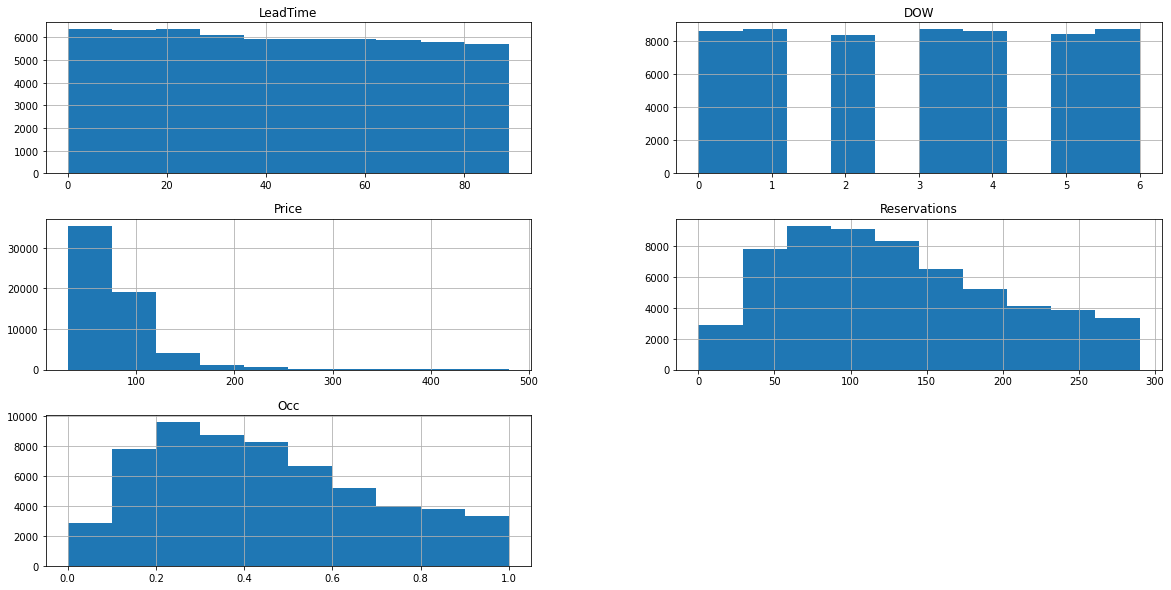

In [33]:
df.hist(figsize=(20,10))
# leadtime
# DOW
# Price: exponential distribution
# Reservation: Gassian distirbution
# Occupancy: Gassian distirbution

## Desnisty Plots 
Density plots are another way of getting a quick idea of the distribution of each attribute. The plots look like an abstracted histogram with a smooth curve drawn through the top of each bin, much like your eye tried to do with the histograms.

array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>], dtype=object)

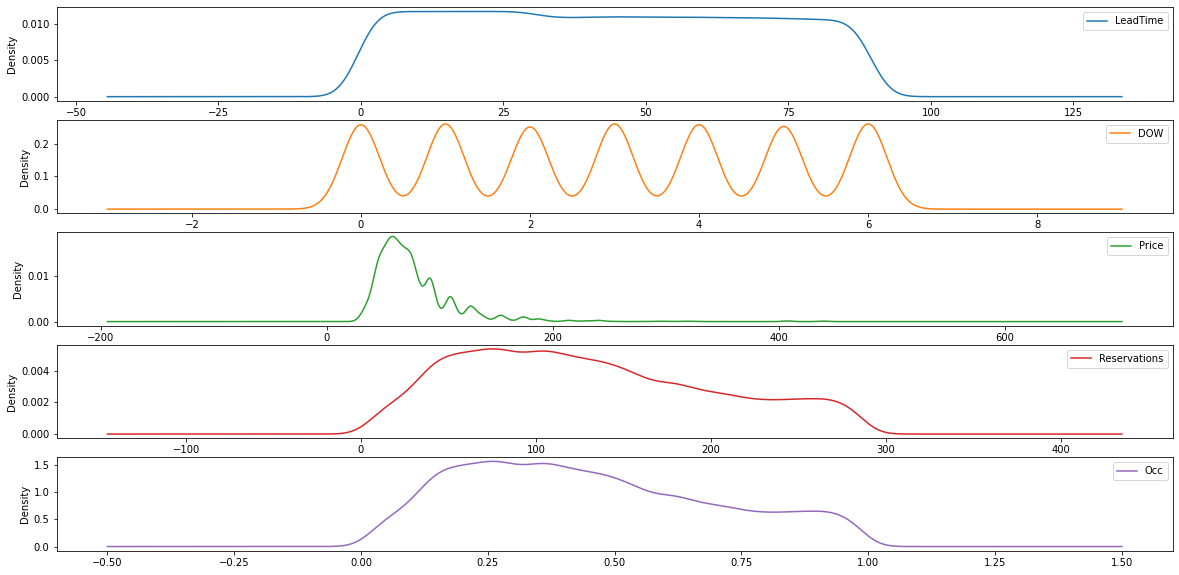

In [34]:
df[['LeadTime','DOW','Price','Reservations','Occ']].plot(kind='density', subplots=True, sharex=False,figsize=(20,10))

## Box and Whisker Plots
Another useful way to review the distribution of each attribute is to use Box and Whisker Plots or boxplots for short. Boxplots summarize the distribution of each attribute, drawing a line for the median (middle value) and a box around the 25th and 75th percentiles (the middle 50% of the data). The whiskers give an idea of the spread of the data and dots outside of the whiskers show candidate outlier values (values that are 1.5 times greater than the size of spread of the middle 50% of the data).

LeadTime           AxesSubplot(0.125,0.657941;0.227941x0.222059)
DOW             AxesSubplot(0.398529,0.657941;0.227941x0.222059)
Price           AxesSubplot(0.672059,0.657941;0.227941x0.222059)
Reservations       AxesSubplot(0.125,0.391471;0.227941x0.222059)
Occ             AxesSubplot(0.398529,0.391471;0.227941x0.222059)
dtype: object

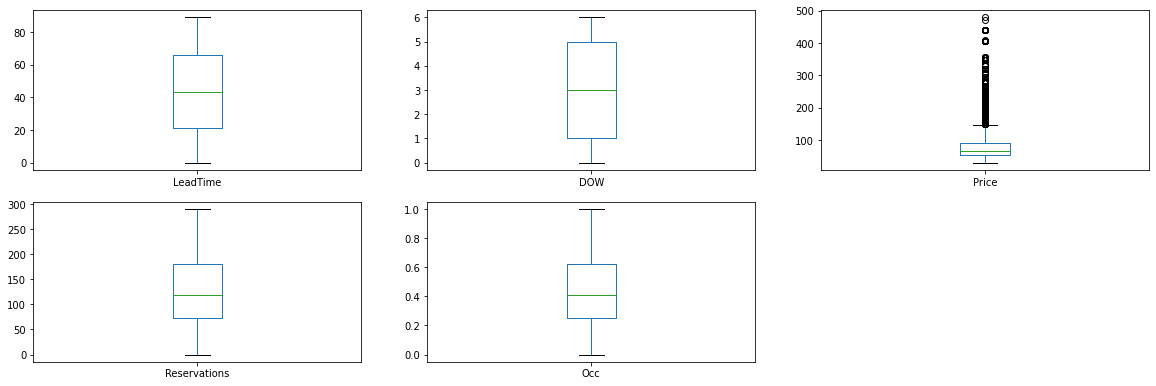

In [38]:
df.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False,figsize=(20,10))
# price: is quire skesed

# Multivariate Plots
## Correlation Matrix Plot
Correlation gives an indication of how related the changes are between two variables. If two variables change in the same direction they are positively correlated. If they change in opposite directions together (one goes up, one goes down), then they are negatively correlated. You can calculate the correlation between each pair of attributes. This is called a correlation matrix. You can then plot the correlation matrix and get an idea of which variables have a high correlation with each other. This is useful to know, because some machine learning algorithms like linear and logistic regression can have poor performance if there are highly correlated input variables in your data.

In [45]:
# !pip install cufflinks
#importing Pandas 
import pandas as pd
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [46]:
df.corr().iplot(kind='heatmap',colorscale="Blues",title="Feature Correlation Matrix")

## Scatter Plot Matrix
A scatter plot shows the relationship between two variables as dots in two dimensions, one axis for each attribute. You can create a scatter plot for each pair of attributes in your data. Drawing all these scatter plots together is called a scatter plot matrix. Scatter plots are useful for spotting structured relationships between variables, like whether you could summarize the relationship between two variables with a line. Attributes with structured relationships may also be correlated and good candidates for removal from your dataset.

Like the Correlation Matrix Plot above, the scatter plot matrix is symmetrical. This is useful to look at the pairwise relationships from different perspectives. Because there is little point of drawing a scatter plot of each variable with itself, the diagonal shows histograms of each attribute.

In [50]:
# df.iplot(kind="scatter", theme="white",x="LeadTime",y="Reservations",categories="DOW")

ValueError: 
    Invalid value of type 'numpy.int64' received for the 'name' property of scatter3d
        Received value: 0

    The 'name' property is a string and must be specified as:
      - A string
      - A number that will be converted to a string